We start with all the needed dependencies.

In [2]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from pylab import rcParams
from sklearn.utils import check_random_state
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
#from sklearn.mixture import GaussianMixture
#from sklearn.svm import LinearSVC, SVC
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier, \
#    GradientBoostingClassifier

max_queried = 500

We start by downloading our data and splitting it to train and test, according to known MNIST definitions 60K/10K split. later the train-set will be split to train and validation.


In [28]:
trainset_size = 60000  # ie., testset_size = 10000

def download():
    # mnist = fetch_mldata('MNIST original')
    mnist = fetch_openml("mnist_784")
    X = mnist.data.astype('float64')
    y = mnist.target
    print ('MNIST:', X.shape, y.shape)
    return (X, y)


def split(train_size):
    X_train_full = X[:train_size]
    y_train_full = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    return (X_train_full, y_train_full, X_test, y_test)


We create a modular class representation, 'BaseModel' is a base model for the class architecture, you can implement new models and use them interchangeably or in addition to all other models.
our current implementations include SVM, logistic regression, random forest and gradient boosting.

In [29]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(C=1, kernel='linear', probability=True,
                              class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class LogModel(BaseModel):

    model_type = 'Multinominal Logistic Regression' 
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training multinomial logistic regression')
        train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight=c_weight,
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)
   

Our 'TrainModel' class accepts one of the previously in defined learning algorithms, trains using the training set and gets performance measurements from the test set.

In [30]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and get probabilities for the validation set. i.e., we use the probabilities to select the most uncertain samples

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape, 'y:', y_train.shape)
        print ('Val   set:', X_val.shape)
        print ('Test  set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)  # we return them in case we use PCA, with all the other algorithms, this is not needed.

    # we want accuracy only for the test set

    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print('Example run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate for %f " % (classif_rate))    
        print("Classification report for classifier %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')


We create a modular selection function class representation, 'BaseSelectionFunction' is a base class for various sample selection methods. Using this architecture, you can implement new selection methods and use them in addition or instead of previous methods, for experimental purposes. Our current implementations include random-selection, entropy-selection, margin sampling-selection and minimum standard deviation-selection.

In [31]:
class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)

#     print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',initial_labeled_samples)

        return selection


class EntropySelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
        return selection
      
      
class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection


We have a class that is used to normalize using a MinMax Scaler in the range of [0,1].

In [32]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

Initially we would like to get a random sampling from the unlabeled data-pool, this is done using random.choice without replacement.

In [33]:
def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size,
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape),
#            permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64'))
    unique = np.unique(y_train.astype('int64'))
    print (
        'initial train set:',
        X_train.shape,
        y_train.shape,
        'unique(labels):',
        bin_count,
        unique,
        )
    return (permutation, X_train, y_train)

This is the main class that initiates the active-learning process according to the algorithm described in the introduction. In short, we select 'k' random samples, train a model, select the most informative samples, remove from the validation set, query their labels and retrain using those samples until reaching the stop criteria.

In [34]:
class TheAlgorithm(object):

    accuracies = []

    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test):

        # initialize process by applying base learner to labeled training data set to obtain Classifier

        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full)
        self.queried = self.initial_labeled_samples
        self.samplecount = [self.initial_labeled_samples]

        # permutation, X_train, y_train = get_equally_k_random_samples(self.initial_labeled_samples,classes)

        # assign the val set the rest of the 'unlabelled' training data

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        print ('val set:', X_val.shape, y_val.shape, permutation.shape)
        print ()

        # normalize data

        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)   
        
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        # fpfn = self.clf_model.test_y_predicted.ravel() != y_val.ravel()
        # print(fpfn)
        # self.fpfncount = []
        # self.fpfncount.append(fpfn.sum() / y_test.shape[0] * 100)

        while self.queried < max_queried:

            active_iteration += 1

            # get validation probabilities

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            print ('val predicted:',
                   self.clf_model.val_y_predicted.shape,
                   self.clf_model.val_y_predicted)
            print ('probabilities:', probas_val.shape, '\n',
                   np.argmax(probas_val, axis=1))

            # select samples using a selection function

            uncertain_samples = \
                self.sample_selection_function.select(probas_val, self.initial_labeled_samples)

            # normalization needs to be inversed and recalculated based on the new train and test set.
 
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set

            print ('trainset before', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print ('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            unique = np.unique(y_train.astype('int64'))
            print (
                'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
                )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print ('val set:', X_val.shape, y_val.shape)
            print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        print ('final active learning accuracies',
               self.clf_model.accuracies)





We download the data, split to train validation and test, we run the experiment by iterating over all of our training algorithms X all of our selection functions X all possible k's in the range of [10,25,50,125,250]. The accuracy results are kept in a dictionary and pickle-saved to a unique file as soon as the model finishes training - this is crucial when using google colaboratory as it tends to disconnect from time to time. We also limit our training to a maximum of 500 queried samples.

In [35]:
(X, y) = download()
(X_train_full, y_train_full, X_test, y_test) = split(trainset_size)
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)

def pickle_save(fname, data):
  filehandler = open(fname,"wb")
  pickle.dump(data,filehandler)
  filehandler.close() 
  print('saved', fname, os.getcwd(), os.listdir())

def pickle_load(fname):
  print(os.getcwd(), os.listdir())
  file = open(fname,'rb')
  data = pickle.load(file)
  file.close()
  print(data)
  return data
  
def experiment(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test)
                    d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                    fname = 'Active-learning-experiment-' + str(count) + '.pkl'
                    pickle_save(fname, d)
                    if count % 5 == 0:
                        print(json.dumps(d, indent=2, sort_keys=True))
                    print ()
                    print ('---------------------------- FINISHED ---------------------------')
                    print ()
    return d


max_queried = 500 

repeats = 1

models = [SvmModel, RfModel, LogModel] 

selection_functions = [RandomSelection, MarginSamplingSelection, EntropySelection] 

Ks = [250,125,50,25,10] 

d = {}
stopped_at = -1 

# print('directory dump including pickle files:', os.getcwd(), np.sort(os.listdir()))  
# d = pickle_load('Active-learning-experiment-' + str(stopped_at) + '.pkl')  
# print(json.dumps(d, indent=2, sort_keys=True))

d = experiment(d, models, selection_functions, Ks, repeats, stopped_at+1)
print (d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
print(results)


MNIST: (70000, 784) (70000,)
train: (60000, 784) (60000,)
test : (10000, 784) (10000,)
unique classes 10
stopping at: 500
Count = 1, using model = SvmModel, selection_function = RandomSelection, k = 250, iteration = 0.

initial random chosen samples (250,)
initial train set: (250, 784) (250,) unique(labels): [22 36 27 28 26 24 20 21 25 21] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 12.021 s 

Accuracy rate for 84.150000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   suppor

Confusion matrix:
[[ 928    0    2    1    2   13   30    3    1    0]
 [   0 1114    2    2    0    3    5    1    8    0]
 [  48   38  785   53   12    6   40   27   19    4]
 [  15   15   10  842    1   62   13   15   27   10]
 [   5    6    7    1  779   14   20   11    1  138]
 [  19   16    7  160   10  627   34    9    3    7]
 [  14    7   18    1   12   19  885    0    0    2]
 [   4   22   11    8   44    7    2  890    6   34]
 [   9   29   58  103   13   82   36   10  582   52]
 [  12    6   10   13  256   18    2   47   10  635]]
--------------------------------
val predicted: (59750,) ['3' '0' '4' ... '5' '6' '5']
probabilities: (59750, 10) 
 [5 0 4 ... 5 6 8]
trainset before (250, 784) (250,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [42 39 38 44 33 32 39 42 30 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training svm...
---------------

Confusion matrix:
[[ 851    1   18    2   17   64    9    6    1   11]
 [   0 1095    1    8   20    6    2    0    3    0]
 [  25   51  775   44   48   22    7   26   14   20]
 [   9   16   44  829   10   40    3   12   35   12]
 [   2   16    3    0  853    2    9    3    0   94]
 [  19   27    3   62   45  631   14    7   45   39]
 [  15   16  134    1   81   29  680    0    2    0]
 [   2   38   19    6   51    5    0  877    0   30]
 [  30   84   73  135   87  119   12    5  337   92]
 [  14   19    2   16  248   10    0   68    8  624]]
--------------------------------
val predicted: (59900,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59900, 10) 
 [5 0 4 ... 5 6 5]
trainset before (100, 784) (100,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [15 10 17 16 22 14 13 19  8 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training svm...
---------------

val predicted: (59700,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59700, 10) 
 [5 0 4 ... 5 6 8]
trainset before (300, 784) (300,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [31 25 39 34 42 33 36 41 36 33] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 15.397 s 

Accuracy rate for 86.580000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.89      0.98      

Confusion matrix:
[[ 930    0    4    2    1   16   21    2    0    4]
 [   0 1111    2    2    0    0    2    0   18    0]
 [  22   61  815   13   24    8   10   19   51    9]
 [   7   13   28  883    3   39    6    9   16    6]
 [   3    6    3    0  884    7    9    0   11   59]
 [  16   11    2   77   14  697   26    3   40    6]
 [   8    7   12    1    8   16  897    0    9    0]
 [   2   27   39    1   25    6    0  871   19   38]
 [  14   27    9   34   17   60   11    5  776   21]
 [   8   10    5   18   66   10    1   38    8  845]]
--------------------------------
final active learning accuracies [67.52, 75.52, 80.19, 84.26, 85.77, 86.16, 86.58, 86.65, 87.18, 87.09]
saved Active-learning-experiment-3.pkl /home/ruslan/Desktop/DoEdu/thirdparty/ActiveLearningFrameworkTutorial ['Active-learning-experiment-2.pkl', 'README.md', 'Active-learning-experiment-1.pkl', 'Active_Learning_Tutorial.ipynb', 'Active-learning-experiment-3.pkl', '.ipynb_checkpoints', 'LICENSE', '.git']

-------

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:
[[ 725    2   74   33   17    0    3   20   40   66]
 [  13 1116    1    0    0    0    0    5    0    0]
 [  57  106  664   46   37    0    1   51   33   37]
 [  89  139  101  387    2    0    0  137  144   11]
 [  10   29   21    1  286    0    0   84    9  542]
 [ 138  168   52   70   16    0    0   55  207  186]
 [  63   79  119   62  226    0  321    6    7   75]
 [  10   49    4    4    5    0    0  767   11  178]
 [  30  183   35   13    9    0    0   51  570   83]
 [  13   22   16    0   57    0    0  172   16  713]]
--------------------------------
val predicted: (59975,) ['0' '0' '7' ... '0' '4' '9']
probabilities: (59975, 9) 
 [0 0 8 ... 0 8 8]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 3  5  3  5  4  1  4  9  6 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
------------------------

val predicted: (59875,) ['3' '0' '3' ... '5' '6' '9']
probabilities: (59875, 10) 
 [3 0 9 ... 5 6 9]
trainset before (125, 784) (125,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 6 14  8 18 14 12 23 18 17 20] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 7.636 s 

Accuracy rate for 80.090000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.93      0.72      0.81       980
           1       0.83      0.99      0

val predicted: (59775,) ['3' '0' '4' ... '5' '6' '9']
probabilities: (59775, 10) 
 [3 0 4 ... 5 6 9]
trainset before (225, 784) (225,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [16 30 18 29 27 21 33 24 24 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 11.863 s 

Accuracy rate for 83.300000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       980
           1       0.84      0.99     

val predicted: (59675,) ['3' '0' '4' ... '5' '6' '9']
probabilities: (59675, 10) 
 [3 0 4 ... 5 6 9]
trainset before (325, 784) (325,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [23 42 27 40 40 29 40 31 42 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 15.847 s 

Accuracy rate for 85.670000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.93      0.86      0.90       980
           1       0.85      0.98     

val predicted: (59575,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59575, 10) 
 [3 0 4 ... 5 6 8]
trainset before (425, 784) (425,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [34 46 42 53 51 37 49 38 56 44] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 19.060 s 

Accuracy rate for 87.630000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.89      0.97     

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59990,) ['2' '0' '4' ... '8' '4' '8']
probabilities: (59990, 6) 
 [1 0 1 ... 3 0 1]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [3 1 5 2 3 1 1 2 1 1] [0 1 2 3 4 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 1.116 s 

Accuracy rate for 41.540000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       980
           1       0.84      0.41      0.55      1135
     

val predicted: (59950,) ['8' '0' '4' ... '8' '6' '4']
probabilities: (59950, 10) 
 [3 0 4 ... 8 6 4]
trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 9  6  6 12  8  2  6  5  5  1] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 3.092 s 

Accuracy rate for 65.020000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       980
           1       0.80      0.97      0.87     

val predicted: (59910,) ['3' '0' '4' ... '8' '6' '4']
probabilities: (59910, 10) 
 [3 0 4 ... 8 6 4]
trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [10  9 10 15 14  5 10 10 11  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 5.013 s 

Accuracy rate for 73.480000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       980
           1       0.82      0.95      0.

val predicted: (59870,) ['3' '0' '4' ... '9' '6' '5']
probabilities: (59870, 10) 
 [3 0 4 ... 9 6 8]
trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [16 15 14 18 16  8 13 15 13 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 6.980 s 

Accuracy rate for 77.680000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       980
           1       0.88      0.95      

val predicted: (59830,) ['3' '0' '4' ... '9' '6' '8']
probabilities: (59830, 10) 
 [3 0 4 ... 3 6 8]
trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [21 23 22 25 19 10 16 15 14 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 8.620 s 

Accuracy rate for 79.590000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       980
           1       0.87      0.98      

val predicted: (59790,) ['3' '0' '4' ... '3' '6' '5']
probabilities: (59790, 10) 
 [3 0 4 ... 9 6 8]
trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [25 29 24 28 24 14 18 16 25 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 10.015 s 

Accuracy rate for 81.480000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       980
           1       0.88      0.98     

val predicted: (59750,) ['3' '0' '4' ... '8' '6' '9']
probabilities: (59750, 10) 
 [3 0 4 ... 5 6 8]
trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [28 33 27 32 34 17 21 19 27 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 11.373 s 

Accuracy rate for 83.010000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       980
           1       0.86      0.98     

val predicted: (59710,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59710, 10) 
 [3 0 4 ... 5 6 8]
trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [34 37 29 37 37 20 27 21 33 25] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 13.448 s 

Accuracy rate for 83.410000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       980
           1       0.88      0.98     

val predicted: (59670,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59670, 10) 
 [3 0 4 ... 5 6 8]
trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [36 40 35 41 38 25 30 24 36 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 14.946 s 

Accuracy rate for 84.260000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.90      0.98     

val predicted: (59630,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59630, 10) 
 [3 0 4 ... 5 6 8]
trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [40 46 40 43 41 27 36 26 42 39] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 16.117 s 

Accuracy rate for 85.390000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       980
           1       0.90      0.98     

val predicted: (59590,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59590, 10) 
 [3 0 4 ... 5 6 8]
trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [44 48 43 46 45 32 40 31 48 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 17.738 s 

Accuracy rate for 86.280000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.90      0.98     

val predicted: (59550,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59550, 10) 
 [3 0 4 ... 5 6 8]
trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [45 51 49 50 50 37 45 34 49 50] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 46
--------------------------------
y-test set: (10000,)
Example run in 19.259 s 

Accuracy rate for 86.560000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.91      0.98     

val predicted: (59510,) ['3' '0' '4' ... '5' '6' '9']
probabilities: (59510, 10) 
 [3 0 4 ... 5 6 9]
trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [47 57 54 56 54 40 47 38 54 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 20.695 s 

Accuracy rate for 86.540000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       980
           1       0.91      0.97     

saved Active-learning-experiment-6.pkl /home/ruslan/Desktop/DoEdu/thirdparty/ActiveLearningFrameworkTutorial ['Active-learning-experiment-4.pkl', 'Active-learning-experiment-2.pkl', 'README.md', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-6.pkl', 'Active-learning-experiment-5.pkl', 'Active_Learning_Tutorial.ipynb', 'Active-learning-experiment-3.pkl', '.ipynb_checkpoints', 'LICENSE', '.git']

---------------------------- FINISHED ---------------------------

Count = 7, using model = SvmModel, selection_function = MarginSamplingSelection, k = 125, iteration = 0.

initial random chosen samples (125,)
initial train set: (125, 784) (125,) unique(labels): [10 13  7 14 16 10  7 17 13 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,) (125,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 6.424 s 

Accuracy

saved Active-learning-experiment-7.pkl /home/ruslan/Desktop/DoEdu/thirdparty/ActiveLearningFrameworkTutorial ['Active-learning-experiment-7.pkl', 'Active-learning-experiment-4.pkl', 'Active-learning-experiment-2.pkl', 'README.md', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-6.pkl', 'Active-learning-experiment-5.pkl', 'Active_Learning_Tutorial.ipynb', 'Active-learning-experiment-3.pkl', '.ipynb_checkpoints', 'LICENSE', '.git']

---------------------------- FINISHED ---------------------------

Count = 8, using model = SvmModel, selection_function = MarginSamplingSelection, k = 50, iteration = 0.

initial random chosen samples (50,)
initial train set: (50, 784) (50,) unique(labels): [2 4 2 5 2 8 6 9 5 7] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,) (50,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in

val predicted: (59800,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59800, 10) 
 [5 0 4 ... 5 6 8]
trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [17 18 29 30 26 27 18 26 30 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 12.571 s 

Accuracy rate for 84.190000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       980
           1       0.91      0.97      

val predicted: (59600,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59600, 10) 
 [5 0 4 ... 5 6 8]
trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [25 24 54 54 61 48 31 43 56 54] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 22.051 s 

Accuracy rate for 87.580000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       980
           1       0.94      0.98      

val predicted: (59950,) ['5' '0' '4' ... '5' '4' '8']
probabilities: (59950, 10) 
 [5 0 4 ... 5 4 9]
trainset before (50, 784) (50,)
trainset after (75, 784) (75,)
updated train set: (75, 784) (75,) unique(labels): [ 6  6  5 11  8  8  9  5  9  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59925, 784) (59925,)

Train set: (75, 784) y: (75,)
Val   set: (59925, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 3.964 s 

Accuracy rate for 70.070000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       980
           1       0.79      0.86      0.83     

val predicted: (59850,) ['5' '0' '4' ... '5' '6' '9']
probabilities: (59850, 10) 
 [5 0 4 ... 5 6 8]
trainset before (150, 784) (150,)
trainset after (175, 784) (175,)
updated train set: (175, 784) (175,) unique(labels): [15 10 23 18 20 23 21 14 13 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59825, 784) (59825,)

Train set: (175, 784) y: (175,)
Val   set: (59825, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 9.214 s 

Accuracy rate for 82.700000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       980
           1       0.90      0.94      0

val predicted: (59750,) ['3' '0' '4' ... '5' '0' '8']
probabilities: (59750, 10) 
 [3 0 4 ... 5 6 5]
trainset before (250, 784) (250,)
trainset after (275, 784) (275,)
updated train set: (275, 784) (275,) unique(labels): [20 14 33 28 29 40 26 27 29 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59725, 784) (59725,)

Train set: (275, 784) y: (275,)
Val   set: (59725, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 14.032 s 

Accuracy rate for 85.530000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       980
           1       0.95      0.94     

val predicted: (59650,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59650, 10) 
 [3 0 4 ... 5 6 8]
trainset before (350, 784) (350,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [23 22 44 42 39 49 35 36 44 41] [0 1 2 3 4 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 18.819 s 

Accuracy rate for 87.740000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       980
           1       0.95      0.96     

val predicted: (59550,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59550, 10) 
 [3 0 4 ... 5 6 8]
trainset before (450, 784) (450,)
trainset after (475, 784) (475,)
updated train set: (475, 784) (475,) unique(labels): [28 28 47 60 44 63 41 49 61 54] [0 1 2 3 4 5 6 7 8 9]
val set: (59525, 784) (59525,)

Train set: (475, 784) y: (475,)
Val   set: (59525, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 23.657 s 

Accuracy rate for 88.420000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.95      0.96     

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59990,) ['7' '1' '3' ... '7' '6' '1']
probabilities: (59990, 5) 
 [3 0 4 ... 3 4 0]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [0 5 1 4 0 2 1 3 1 3] [1 2 3 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 1.108 s 

Accuracy rate for 39.120000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.50      0.95      0.66      1135
         

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59980,) ['3' '5' '3' ... '5' '6' '5']
probabilities: (59980, 8) 
 [2 5 2 ... 2 5 5]
trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [3 5 2 4 1 2 1 6 2 4] [0 1 2 3 4 5 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 1.655 s 

Accuracy rate for 51.550000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.65      0.85      0.74       980
           1       0.61      0.92      0.74      1135
     

val predicted: (59940,) ['5' '0' '0' ... '5' '6' '8']
probabilities: (59940, 10) 
 [5 0 0 ... 5 6 5]
trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 4  7 10  7  4  7  4  9  9  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 3.790 s 

Accuracy rate for 72.460000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       980
           1       0.82      0.98      0.89     

val predicted: (59900,) ['5' '0' '9' ... '5' '6' '5']
probabilities: (59900, 10) 
 [5 0 2 ... 5 6 5]
trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [ 6  8 14 13  8 12  9 14 13 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 5.817 s 

Accuracy rate for 79.010000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       980
           1       0.90      0.98      

val predicted: (59860,) ['5' '0' '2' ... '5' '6' '8']
probabilities: (59860, 10) 
 [5 0 2 ... 5 6 8]
trainset before (140, 784) (140,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [10 10 21 17 14 18 11 17 15 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 7.829 s 

Accuracy rate for 81.540000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       980
           1       0.91      0.98      

val predicted: (59820,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59820, 10) 
 [5 0 4 ... 5 6 8]
trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [14 11 23 20 19 19 16 22 23 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 10.000 s 

Accuracy rate for 83.360000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       980
           1       0.92      0.97     

val predicted: (59780,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59780, 10) 
 [5 0 4 ... 5 6 8]
trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [17 13 27 24 23 26 18 28 26 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 11.890 s 

Accuracy rate for 84.030000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       980
           1       0.92      0.99     

val predicted: (59740,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59740, 10) 
 [5 0 4 ... 5 6 8]
trainset before (260, 784) (260,)
trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [18 15 30 28 27 32 22 32 30 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59730, 784) (59730,)

Train set: (270, 784) y: (270,)
Val   set: (59730, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 27
--------------------------------
y-test set: (10000,)
Example run in 13.884 s 

Accuracy rate for 85.240000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       980
           1       0.92      0.99     

val predicted: (59700,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59700, 10) 
 [5 0 4 ... 5 6 8]
trainset before (300, 784) (300,)
trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [22 15 33 31 37 38 23 38 33 40] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)

Train set: (310, 784) y: (310,)
Val   set: (59690, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 31
--------------------------------
y-test set: (10000,)
Example run in 15.709 s 

Accuracy rate for 85.570000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       980
           1       0.94      0.98     

val predicted: (59660,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59660, 10) 
 [5 0 4 ... 5 6 9]
trainset before (340, 784) (340,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [26 17 35 37 39 41 25 43 38 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 35
--------------------------------
y-test set: (10000,)
Example run in 17.957 s 

Accuracy rate for 86.540000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       980
           1       0.94      0.98     

val predicted: (59620,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59620, 10) 
 [5 0 4 ... 5 6 5]
trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [27 20 37 42 45 49 28 46 45 51] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 39
--------------------------------
y-test set: (10000,)
Example run in 20.068 s 

Accuracy rate for 87.410000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       980
           1       0.94      0.98     

val predicted: (59580,) ['5' '0' '4' ... '5' '6' '9']
probabilities: (59580, 10) 
 [5 0 4 ... 5 6 5]
trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [28 21 40 45 48 56 33 51 53 55] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 22.094 s 

Accuracy rate for 87.900000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       980
           1       0.94      0.98     

val predicted: (59540,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59540, 10) 
 [5 0 4 ... 5 6 5]
trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [30 24 43 46 50 62 42 54 58 61] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 23.950 s 

Accuracy rate for 88.430000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.94      0.99     

saved Active-learning-experiment-10.pkl /home/ruslan/Desktop/DoEdu/thirdparty/ActiveLearningFrameworkTutorial ['Active-learning-experiment-7.pkl', 'Active-learning-experiment-4.pkl', 'Active-learning-experiment-2.pkl', 'README.md', 'Active-learning-experiment-9.pkl', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-6.pkl', 'Active-learning-experiment-10.pkl', 'Active-learning-experiment-5.pkl', 'Active-learning-experiment-8.pkl', 'Active_Learning_Tutorial.ipynb', 'Active-learning-experiment-3.pkl', '.ipynb_checkpoints', 'LICENSE', '.git']
{
  "SvmModel": {
    "MarginSamplingSelection": {
      "10": [
        [
          24.41,
          39.12,
          51.55,
          58.15,
          64.19,
          67.33,
          72.46000000000001,
          73.94,
          78.06,
          78.57,
          79.01,
          78.68,
          79.80000000000001,
          80.78999999999999,
          81.54,
          82.21000000000001,
          82.08,
          83.17999999999999,

saved Active-learning-experiment-11.pkl /home/ruslan/Desktop/DoEdu/thirdparty/ActiveLearningFrameworkTutorial ['Active-learning-experiment-7.pkl', 'Active-learning-experiment-4.pkl', 'Active-learning-experiment-2.pkl', 'Active-learning-experiment-11.pkl', 'README.md', 'Active-learning-experiment-9.pkl', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-6.pkl', 'Active-learning-experiment-10.pkl', 'Active-learning-experiment-5.pkl', 'Active-learning-experiment-8.pkl', 'Active_Learning_Tutorial.ipynb', 'Active-learning-experiment-3.pkl', '.ipynb_checkpoints', 'LICENSE', '.git']

---------------------------- FINISHED ---------------------------

Count = 12, using model = SvmModel, selection_function = EntropySelection, k = 125, iteration = 0.

initial random chosen samples (125,)
initial train set: (125, 784) (125,) unique(labels): [15 22 16 13 15  8  9 11  5 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,) (125,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 7

saved Active-learning-experiment-12.pkl /home/ruslan/Desktop/DoEdu/thirdparty/ActiveLearningFrameworkTutorial ['Active-learning-experiment-7.pkl', 'Active-learning-experiment-4.pkl', 'Active-learning-experiment-2.pkl', 'Active-learning-experiment-11.pkl', 'README.md', 'Active-learning-experiment-9.pkl', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-12.pkl', 'Active-learning-experiment-6.pkl', 'Active-learning-experiment-10.pkl', 'Active-learning-experiment-5.pkl', 'Active-learning-experiment-8.pkl', 'Active_Learning_Tutorial.ipynb', 'Active-learning-experiment-3.pkl', '.ipynb_checkpoints', 'LICENSE', '.git']

---------------------------- FINISHED ---------------------------

Count = 13, using model = SvmModel, selection_function = EntropySelection, k = 50, iteration = 0.

initial random chosen samples (50,)
initial train set: (50, 784) (50,) unique(labels): [ 3  6  5  4  7  5  3  3 10  4] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,) (50,)

Train set: (50, 784)

Confusion matrix:
[[ 696    0    5    5    5  224   34    2    8    1]
 [   0 1028    1    6    0    7    2   11   79    1]
 [  11   45  634  111   27   31   38   13  111   11]
 [   0   11    3  662    2  119    8   12  175   18]
 [   3    7    4    1  758    9   12   17   10  161]
 [   6    6   18  116    7  555   12    6  140   26]
 [  16    2   55    4  108   75  670    0   28    0]
 [  10   27    7   99   44   11    2  762   11   55]
 [   5   28    8   29   19   64   10    7  790   14]
 [   6   12    8   15  358   17    1   51   32  509]]
--------------------------------
val predicted: (59800,) ['3' '0' '9' ... '5' '6' '8']
probabilities: (59800, 10) 
 [3 0 9 ... 5 6 8]
trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [13 15 22 26 18 38 17 32 43 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
---------------

val predicted: (59600,) ['5' '0' '9' ... '5' '6' '8']
probabilities: (59600, 10) 
 [5 0 9 ... 5 6 8]
trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [41 26 57 42 44 55 28 54 61 42] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 22.800 s 

Accuracy rate for 77.950000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       980
           1       0.88      0.92      

val predicted: (59950,) ['7' '0' '4' ... '7' '6' '7']
probabilities: (59950, 10) 
 [7 0 6 ... 7 6 7]
trainset before (50, 784) (50,)
trainset after (75, 784) (75,)
updated train set: (75, 784) (75,) unique(labels): [ 6  5  2  8  2 27 16  3  4  2] [0 1 2 3 4 5 6 7 8 9]
val set: (59925, 784) (59925,)

Train set: (75, 784) y: (75,)
Val   set: (59925, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 3.956 s 

Accuracy rate for 58.500000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       980
           1       0.81      0.92      0.86     

val predicted: (59850,) ['5' '0' '6' ... '5' '6' '8']
probabilities: (59850, 10) 
 [5 0 5 ... 5 6 8]
trainset before (150, 784) (150,)
trainset after (175, 784) (175,)
updated train set: (175, 784) (175,) unique(labels): [ 9 11 30 12 20 32 20 10 22  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59825, 784) (59825,)

Train set: (175, 784) y: (175,)
Val   set: (59825, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 9.048 s 

Accuracy rate for 72.370000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       980
           1       0.85      0.93      0

--------------------------------
val predicted: (59750,) ['8' '0' '4' ... '5' '6' '8']
probabilities: (59750, 10) 
 [5 0 4 ... 5 6 8]
trainset before (250, 784) (250,)
trainset after (275, 784) (275,)
updated train set: (275, 784) (275,) unique(labels): [12 17 45 27 28 42 26 19 40 19] [0 1 2 3 4 5 6 7 8 9]
val set: (59725, 784) (59725,)

Train set: (275, 784) y: (275,)
Val   set: (59725, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 13.824 s 

Accuracy rate for 73.110000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       980
     

val predicted: (59650,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59650, 10) 
 [5 0 4 ... 5 6 8]
trainset before (350, 784) (350,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [25 22 57 39 37 52 37 28 49 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 19.142 s 

Accuracy rate for 76.790000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       980
           1       0.82      0.96     

val predicted: (59550,) ['5' '0' '3' ... '5' '6' '3']
probabilities: (59550, 10) 
 [5 0 3 ... 5 6 8]
trainset before (450, 784) (450,)
trainset after (475, 784) (475,)
updated train set: (475, 784) (475,) unique(labels): [28 33 77 46 45 68 44 38 62 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59525, 784) (59525,)

Train set: (475, 784) y: (475,)
Val   set: (59525, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 23.900 s 

Accuracy rate for 78.300000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       980
           1       0.85      0.96     

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59990,) ['8' '0' '7' ... '8' '0' '9']
probabilities: (59990, 8) 
 [5 6 0 ... 0 0 6]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [4 1 0 3 0 1 1 1 6 3] [0 1 3 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 1.108 s 

Accuracy rate for 36.500000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.36      0.88      0.51       980
           1       0.73      0.47      0.58      1135
         

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59980,) ['9' '0' '7' ... '8' '0' '9']
probabilities: (59980, 8) 
 [2 0 2 ... 6 0 6]
trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [7 1 2 6 0 1 1 1 8 3] [0 1 2 3 5 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 1.590 s 

Accuracy rate for 41.500000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.55      0.92      0.69       980
           1       0.62      0.48      0.54      1135
       

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59970,) ['9' '0' '7' ... '8' '0' '9']
probabilities: (59970, 9) 
 [3 0 0 ... 7 0 7]
trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [ 7  1  2 16  0  1  1  1  8  3] [0 1 2 3 5 6 7 8 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 1.907 s 

Accuracy rate for 41.700000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.55      0.93      0.69       980
           1       0.62      0.48      0.54      11

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59960,) ['9' '0' '7' ... '8' '0' '9']
probabilities: (59960, 9) 
 [3 0 0 ... 7 0 7]
trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 7  1  8 20  0  1  1  1  8  3] [0 1 2 3 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 2.332 s 

Accuracy rate for 43.050000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.57      0.92      0.70       980
           1       0.67      0.48      0.56      11

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59950,) ['9' '0' '7' ... '8' '0' '9']
probabilities: (59950, 9) 
 [3 0 3 ... 7 0 7]
trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 7  1  8 20  0  1  1  5  8  9] [0 1 2 3 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 2.866 s 

Accuracy rate for 46.930000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.59      0.91      0.71       980
           1       0.65      0.47      0.55      11

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59940,) ['9' '0' '3' ... '8' '0' '9']
probabilities: (59940, 9) 
 [8 0 3 ... 7 0 8]
trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [11  1  8 20  5  1  1  5  8 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 3.410 s 

Accuracy rate for 50.620000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.61      0.97      0.75       980
           1       0.70      0.47      0.56      

val predicted: (59900,) ['9' '0' '4' ... '8' '6' '9']
probabilities: (59900, 10) 
 [9 0 4 ... 9 6 9]
trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [12  1 13 23  8  7 19  5 12 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 5.130 s 

Accuracy rate for 56.840000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       980
           1       0.83      0.43      

val predicted: (59860,) ['9' '0' '4' ... '5' '6' '8']
probabilities: (59860, 10) 
 [9 0 4 ... 5 6 8]
trainset before (140, 784) (140,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [14  1 19 24 15 16 21 10 17 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 7.074 s 

Accuracy rate for 62.030000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       980
           1       0.87      0.40      

val predicted: (59820,) ['8' '0' '4' ... '5' '6' '8']
probabilities: (59820, 10) 
 [9 0 4 ... 5 6 8]
trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [18  1 24 26 19 20 23 15 25 19] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 8.827 s 

Accuracy rate for 65.230000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       980
           1       0.90      0.38      

val predicted: (59780,) ['9' '0' '4' ... '5' '6' '9']
probabilities: (59780, 10) 
 [9 0 4 ... 5 6 9]
trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [22 12 27 27 24 22 26 22 27 21] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 10.532 s 

Accuracy rate for 69.550000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       980
           1       0.91      0.32     

val predicted: (59740,) ['5' '0' '4' ... '5' '6' '9']
probabilities: (59740, 10) 
 [5 0 4 ... 5 6 9]
trainset before (260, 784) (260,)
trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [25 13 34 32 29 28 31 25 31 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59730, 784) (59730,)

Train set: (270, 784) y: (270,)
Val   set: (59730, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 27
--------------------------------
y-test set: (10000,)
Example run in 12.580 s 

Accuracy rate for 74.930000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       980
           1       0.95      0.64     

val predicted: (59700,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59700, 10) 
 [5 0 4 ... 5 6 8]
trainset before (300, 784) (300,)
trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [25 21 39 37 32 33 33 28 36 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)

Train set: (310, 784) y: (310,)
Val   set: (59690, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 31
--------------------------------
y-test set: (10000,)
Example run in 14.710 s 

Accuracy rate for 75.790000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       980
           1       0.92      0.80     

val predicted: (59660,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59660, 10) 
 [5 0 4 ... 5 6 8]
trainset before (340, 784) (340,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [28 25 45 42 34 38 37 31 40 30] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 35
--------------------------------
y-test set: (10000,)
Example run in 16.829 s 

Accuracy rate for 80.160000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       980
           1       0.93      0.90     

Confusion matrix:
[[ 903    0    5    4    2   25   23   13    4    1]
 [   0 1010    2    6    0    3    3    7  104    0]
 [  40   18  776   56   17    5   46   15   53    6]
 [  11    3   43  846    1   40    4   16   21   25]
 [   2    1    5    6  682   17   15   14   35  205]
 [  56   15   11  161   11  499   10   14   86   29]
 [  26    6   12    4   40   23  820    0   27    0]
 [   5   16   23    2    6    4    0  840    8  124]
 [  17   32   31   73    8   32    6   24  739   12]
 [  11    4    4    8   36   19    0   59   50  818]]
--------------------------------
val predicted: (59620,) ['5' '0' '4' ... '9' '6' '8']
probabilities: (59620, 10) 
 [5 0 4 ... 9 6 8]
trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [35 28 50 46 40 44 38 31 42 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training svm...
---------------

val predicted: (59580,) ['5' '0' '4' ... '9' '6' '8']
probabilities: (59580, 10) 
 [5 0 4 ... 5 6 8]
trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [38 29 55 51 41 51 41 37 48 39] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 20.867 s 

Accuracy rate for 78.780000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       980
           1       0.91      0.85     

val predicted: (59540,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59540, 10) 
 [5 0 4 ... 5 6 8]
trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [39 30 57 55 45 65 43 40 54 42] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 22.958 s 

Accuracy rate for 79.600000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       980
           1       0.92      0.86     

val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 5.056 s 

Accuracy rate for 79.440000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.91      0.69      0.78       980
 

trainset before (125, 784) (125,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [31 27 25 24 25 21 31 16 23 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 4.990 s 

Accuracy rate for 83.130000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

val set: (59950, 784) (59950,) (50,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 3.960 s 

Accuracy rate for 58.270000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.69      0.95      0.80       980
    

Confusion matrix:
[[ 953    1    2    0    0   15    6    1    2    0]
 [   0 1115   11    3    0    0    2    3    1    0]
 [  40   59  838   13   16    2    7   27   21    9]
 [  27   12   40  766    0  100    1   24   26   14]
 [   4   16   12    0  779    3    7   12    5  144]
 [  47   31   11   70   34  629    7   21    9   33]
 [  77   20   60    0   69   36  693    2    1    0]
 [   7   41   24    0   14    2    1  912    1   26]
 [  14   44   31   31   16   47    4   20  729   38]
 [  11   13   10    4   60    8    0   51   12  840]]
--------------------------------
val predicted: (59800,) ['3' '0' '4' ... '5' '6' '2']
probabilities: (59800, 10) 
 [3 0 4 ... 5 6 2]
trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [35 28 23 24 25 21 14 27 26 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
-----

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 5.414 s 

Accuracy rate for 84.890000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       980
           1       0.89      0.98      0

val set: (59975, 784) (59975,) (25,)

Train set: (25, 784) y: (25,)
Val   set: (59975, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 3.384 s 

Accuracy rate for 35.360000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.78      0.16      0.26       980
    

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59975,) ['3' '6' '9' ... '9' '6' '9']
probabilities: (59975, 9) 
 [3 5 8 ... 8 5 8]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 5  3  6 10  2  4  5  5  3  7] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 3.977 s 

Accuracy rate for 60.410000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf

val predicted: (59875,) ['3' '0' '4' ... '5' '0' '8']
probabilities: (59875, 10) 
 [3 0 4 ... 5 0 8]
trainset before (125, 784) (125,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [14 15 15 19 15 13 10 19 15 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 4.610 s 

Accuracy rate for 80.600000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_frac

val predicted: (59775,) ['5' '0' '4' ... '5' '0' '8']
probabilities: (59775, 10) 
 [5 0 4 ... 5 0 8]
trainset before (225, 784) (225,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [25 27 25 31 28 23 16 28 23 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 4.971 s 

Accuracy rate for 83.530000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59675,) ['5' '0' '4' ... '5' '0' '8']
probabilities: (59675, 10) 
 [5 0 4 ... 5 0 8]
trainset before (325, 784) (325,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [32 37 28 48 36 41 25 39 28 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 5.284 s 

Accuracy rate for 85.810000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59575,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59575, 10) 
 [5 0 4 ... 5 6 8]
trainset before (425, 784) (425,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [36 54 43 53 47 47 34 48 40 48] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 5.515 s 

Accuracy rate for 87.810000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val set: (59990, 784) (59990,) (10,)

Train set: (10, 784) y: (10,)
Val   set: (59990, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 2.913 s 

Accuracy rate for 28.470000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.64      0.47      0.54       980
    

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59990,) ['7' '0' '7' ... '7' '7' '7']
probabilities: (59990, 8) 
 [5 0 5 ... 5 5 5]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [1 2 2 2 3 1 1 2 1 5] [0 1 2 3 4 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 3.563 s 

Accuracy rate for 35.380000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_es

val predicted: (59950,) ['5' '0' '4' ... '5' '4' '4']
probabilities: (59950, 10) 
 [5 0 4 ... 5 4 4]
trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [6 7 4 7 8 7 6 4 3 8] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 4.254 s 

Accuracy rate for 61.300000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_e

val predicted: (59910,) ['5' '0' '4' ... '5' '6' '9']
probabilities: (59910, 10) 
 [5 0 4 ... 5 6 9]
trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 9 10  9 11 11 11 11  8  6 14] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 4.450 s 

Accuracy rate for 71.580000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fract

val predicted: (59870,) ['3' '0' '4' ... '5' '0' '9']
probabilities: (59870, 10) 
 [3 0 4 ... 5 0 9]
trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [14 16 12 15 18 12 14 12 10 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 4.694 s 

Accuracy rate for 77.310000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59830,) ['5' '0' '4' ... '5' '0' '9']
probabilities: (59830, 10) 
 [5 0 4 ... 5 0 9]
trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [17 20 14 18 23 16 21 17 11 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 4.832 s 

Accuracy rate for 78.640000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59790,) ['3' '0' '4' ... '5' '0' '9']
probabilities: (59790, 10) 
 [3 0 4 ... 5 0 9]
trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [22 24 17 21 25 22 25 22 15 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 4.956 s 

Accuracy rate for 80.120000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59750,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59750, 10) 
 [3 0 4 ... 5 6 8]
trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [25 27 21 25 27 27 31 24 19 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 5.146 s 

Accuracy rate for 82.820000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59710,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59710, 10) 
 [5 0 4 ... 5 6 8]
trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [28 30 27 28 29 31 40 25 23 39] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 5.270 s 

Accuracy rate for 84.190000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59670,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59670, 10) 
 [5 0 4 ... 5 6 8]
trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [32 37 33 29 34 34 44 29 27 41] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 5.377 s 

Accuracy rate for 84.990000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59630,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59630, 10) 
 [5 0 4 ... 5 6 8]
trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [34 41 38 33 38 38 46 32 34 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 5.491 s 

Accuracy rate for 86.180000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59590,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59590, 10) 
 [5 0 4 ... 5 6 8]
trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [36 49 42 36 45 44 47 36 34 51] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 5.577 s 

Accuracy rate for 85.930000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59550,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59550, 10) 
 [5 0 4 ... 5 6 8]
trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [40 50 49 41 48 50 52 37 39 54] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 46
--------------------------------
y-test set: (10000,)
Example run in 5.671 s 

Accuracy rate for 87.240000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59510,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59510, 10) 
 [5 0 4 ... 5 6 8]
trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [45 55 51 44 52 59 55 41 41 57] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 5.773 s 

Accuracy rate for 87.520000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 5.001 s 

Accuracy rate for 80.640000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.94      0.82      0.87       980
 

val predicted: (59875,) ['5' '0' '4' ... '5' '0' '5']
probabilities: (59875, 10) 
 [5 0 4 ... 5 0 5]
trainset before (125, 784) (125,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [23 15 27 31 22 27 24 18 39 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 5.298 s 

Accuracy rate for 86.380000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_frac

val set: (59950, 784) (59950,) (50,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 3.938 s 

Accuracy rate for 57.740000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.49      0.95      0.65       980
    

val predicted: (59800,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59800, 10) 
 [5 0 4 ... 5 6 8]
trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [20 12 30 26 29 28 20 20 33 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 5.246 s 

Accuracy rate for 88.260000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_frac

val predicted: (59600,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59600, 10) 
 [5 0 4 ... 5 6 8]
trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [33 19 52 53 47 56 35 41 59 55] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 5.995 s 

Accuracy rate for 91.020000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_frac

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59975,) ['0' '0' '4' ... '7' '6' '8']
probabilities: (59975, 9) 
 [0 0 4 ... 6 5 7]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [3 5 6 5 5 7 5 7 4 3] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 4.160 s 

Accuracy rate for 63.860000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_es

val predicted: (59875,) ['0' '4' '1' ... '5' '0' '8']
probabilities: (59875, 10) 
 [0 4 1 ... 5 0 8]
trainset before (125, 784) (125,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [12  7 21 15 17 19 14 12 16 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 4.914 s 

Accuracy rate for 83.190000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_frac

val predicted: (59775,) ['0' '4' '1' ... '5' '6' '8']
probabilities: (59775, 10) 
 [0 4 1 ... 5 6 8]
trainset before (225, 784) (225,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [17 12 27 28 33 31 23 20 28 31] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 5.426 s 

Accuracy rate for 86.730000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59675,) ['0' '4' '1' ... '5' '6' '8']
probabilities: (59675, 10) 
 [0 4 1 ... 5 6 8]
trainset before (325, 784) (325,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [20 15 37 41 38 51 31 28 44 45] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 6.001 s 

Accuracy rate for 89.650000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59575,) ['0' '4' '1' ... '3' '5' '6']
probabilities: (59575, 10) 
 [0 4 1 ... 3 5 6]
trainset before (425, 784) (425,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [24 20 48 57 48 60 37 41 58 57] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 6.159 s 

Accuracy rate for 91.640000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val set: (59990, 784) (59990,) (10,)

Train set: (10, 784) y: (10,)
Val   set: (59990, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 2.747 s 

Accuracy rate for 26.560000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.21      0.98      0.34       980
    

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59990,) ['0' '0' '0' ... '1' '0' '0']
probabilities: (59990, 7) 
 [0 0 0 ... 1 0 0]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [4 2 1 2 2 2 2 1 2 2] [0 1 2 3 4 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 3.659 s 

Accuracy rate for 45.550000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_es

val predicted: (59950,) ['3' '0' '4' ... '9' '0' '9']
probabilities: (59950, 10) 
 [3 0 4 ... 9 0 9]
trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [5 4 7 5 6 8 5 5 7 8] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 4.275 s 

Accuracy rate for 71.170000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_e

val predicted: (59910,) ['3' '0' '4' ... '5' '0' '8']
probabilities: (59910, 10) 
 [3 0 4 ... 5 0 8]
trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 7  6 12 10 12 10 12  7 13 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 4.643 s 

Accuracy rate for 79.690000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fract

val predicted: (59870,) ['3' '0' '4' ... '3' '6' '8']
probabilities: (59870, 10) 
 [3 0 4 ... 3 6 8]
trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [10  7 14 17 17 15 13 11 19 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 4.889 s 

Accuracy rate for 84.990000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59830,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59830, 10) 
 [3 0 4 ... 5 6 8]
trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [12  7 22 20 21 19 14 16 26 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 5.116 s 

Accuracy rate for 86.070000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59790,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59790, 10) 
 [5 0 4 ... 5 6 8]
trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [13  7 27 24 26 24 19 20 34 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 5.321 s 

Accuracy rate for 87.930000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59750,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59750, 10) 
 [5 0 4 ... 5 6 8]
trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [13  8 31 32 29 33 25 22 38 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 5.489 s 

Accuracy rate for 89.710000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59710,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59710, 10) 
 [5 0 4 ... 5 6 8]
trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [17  9 36 39 33 39 26 25 42 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 5.679 s 

Accuracy rate for 90.490000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59670,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59670, 10) 
 [5 0 4 ... 5 6 8]
trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [19 13 42 44 35 44 29 27 46 41] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 5.739 s 

Accuracy rate for 91.070000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59630,) ['0' '4' '1' ... '5' '6' '8']
probabilities: (59630, 10) 
 [0 4 1 ... 5 6 8]
trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [21 15 45 47 41 52 31 32 50 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 5.887 s 

Accuracy rate for 91.380000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59590,) ['0' '4' '1' ... '5' '6' '8']
probabilities: (59590, 10) 
 [0 4 1 ... 5 6 8]
trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [23 15 48 53 47 55 34 35 57 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 6.030 s 

Accuracy rate for 91.560000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59550,) ['0' '4' '1' ... '5' '6' '8']
probabilities: (59550, 10) 
 [0 4 1 ... 5 6 8]
trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [30 15 51 56 53 60 39 37 60 59] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 46
--------------------------------
y-test set: (10000,)
Example run in 6.136 s 

Accuracy rate for 92.430000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val predicted: (59510,) ['0' '4' '1' ... '5' '6' '8']
probabilities: (59510, 10) 
 [0 4 1 ... 5 6 8]
trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [30 16 57 62 53 67 41 42 69 63] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 6.263 s 

Accuracy rate for 92.800000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fra

val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 4.993 s 

Accuracy rate for 82.870000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       980
 

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 70 154  26  42  27  25  24  78  21  33] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 5.469 s 

Accuracy rate for 81.830000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (125, 784) (125,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [33 30 14 16 14  5 38 53 13 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 5.029 s 

Accuracy rate for 73.650000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [41 68 17 17 17  6 49 93 14 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 5.124 s 

Accuracy rate for 74.140000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (375, 784) (375,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 53 123  25  17  17   6  53 131  14  61] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 5.383 s 

Accuracy rate for 74.590000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [10 24  2 12  6  9 10  7  8 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 4.442 s 

Accuracy rate for 65.070000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [10 54  3 18  7 14 10  9  8 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 4.480 s 

Accuracy rate for 65.140000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [13 77  3 27  9 16 10 14  9 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 4.745 s 

Accuracy rate for 65.880000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [ 15 104   3  29  11  21  10  18   9  30] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 4.767 s 

Accuracy rate for 64.940000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [ 18 132   3  31  13  23  10  22   9  39] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 4.981 s 

Accuracy rate for 65.430000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [ 20 157   3  32  16  26  11  27  10  48] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 4.991 s 

Accuracy rate for 66.640000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [ 21 171   3  36  23  30  11  37  12  56] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 5.283 s 

Accuracy rate for 69.800000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [ 23 187   3  40  28  34  12  47  12  64] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 5.257 s 

Accuracy rate for 69.130000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 24 201   3  45  30  36  12  65  12  72] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 5.479 s 

Accuracy rate for 69.860000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59975,) ['0' '0' '9' ... '5' '6' '1']
probabilities: (59975, 9) 
 [0 0 8 ... 5 6 1]


/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 5  2  5  2  3  5 11  5  8  4] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 4.039 s 

Accuracy rate for 57.490000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (75, 784) (75,)
updated train set: (75, 784) (75,) unique(labels): [ 5  2  6  2 11  5 13 13  8 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59925, 784) (59925,)

Train set: (75, 784) y: (75,)
Val   set: (59925, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 4.203 s 

Accuracy rate for 63.130000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (75, 784) (75,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 6  2  7  2 19  5 15 15 10 19] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 4.485 s 

Accuracy rate for 65.530000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (125, 784) (125,)
updated train set: (125, 784) (125,) unique(labels): [ 6  2  7  2 29  7 16 20 11 25] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 4.491 s 

Accuracy rate for 69.400000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (125, 784) (125,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 6  2  8  2 40  9 16 23 12 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 4.698 s 

Accuracy rate for 69.730000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (175, 784) (175,)
updated train set: (175, 784) (175,) unique(labels): [ 6  2  8  2 45 11 18 28 12 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59825, 784) (59825,)

Train set: (175, 784) y: (175,)
Val   set: (59825, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 4.638 s 

Accuracy rate for 69.320000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (175, 784) (175,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [ 6  2  8  2 56 12 19 31 12 52] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 4.863 s 

Accuracy rate for 66.680000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [ 6  2  9  2 62 13 19 37 14 61] [0 1 2 3 4 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 4.865 s 

Accuracy rate for 67.250000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (225, 784) (225,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [ 6  2  9  2 73 13 20 40 16 69] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 5.085 s 

Accuracy rate for 66.980000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (275, 784) (275,)
updated train set: (275, 784) (275,) unique(labels): [ 6  2  9  2 77 13 21 52 17 76] [0 1 2 3 4 5 6 7 8 9]
val set: (59725, 784) (59725,)

Train set: (275, 784) y: (275,)
Val   set: (59725, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 5.004 s 

Accuracy rate for 66.370000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (275, 784) (275,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [ 8  2  9  2 82 15 22 60 18 82] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 5.184 s 

Accuracy rate for 68.220000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [10  2  9  2 90 16 23 66 19 88] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 5.183 s 

Accuracy rate for 66.180000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (325, 784) (325,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [13  2  9  2 94 16 24 72 23 95] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 5.370 s 

Accuracy rate for 67.420000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [ 15   2   9   2 101  17  24  80  26  99] [0 1 2 3 4 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 5.304 s 

Accuracy rate for 67.680000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (375, 784) (375,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [ 15   2  10   2 107  20  27  86  26 105] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 5.506 s 

Accuracy rate for 67.640000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [ 15   3  10   2 113  20  31  90  28 113] [0 1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 5.420 s 

Accuracy rate for 70.990000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (425, 784) (425,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [ 15   3  10   2 119  21  34  95  31 120] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 5.616 s 

Accuracy rate for 70.590000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (475, 784) (475,)
updated train set: (475, 784) (475,) unique(labels): [ 15   3  10   2 125  24  36 101  32 127] [0 1 2 3 4 5 6 7 8 9]
val set: (59525, 784) (59525,)

Train set: (475, 784) y: (475,)
Val   set: (59525, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 5.561 s 

Accuracy rate for 70.810000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (475, 784) (475,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 17   5  12   2 126  27  37 109  34 131] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 5.721 s 

Accuracy rate for 72.480000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59990,) ['7' '8' '3' ... '8' '7' '8']
probabilities: (59990, 5) 
 [2 3 0 ... 3 2 3]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [1 0 0 2 4 1 2 4 4 2] [0 3 4 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 3.209 s 

Accuracy rate for 27.010000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estima

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59980,) ['7' '8' '4' ... '8' '7' '8']
probabilities: (59980, 8) 
 [5 6 2 ... 6 5 6]


/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [1 0 1 2 6 1 4 7 6 2] [0 2 3 4 5 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 3.515 s 

Accuracy rate for 32.070000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59970,) ['7' '7' '4' ... '7' '7' '8']
probabilities: (59970, 9) 
 [6 6 3 ... 6 6 7]


/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [ 1  0  3  3  7  1  6 10  7  2] [0 2 3 4 5 6 7 8 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 3.829 s 

Accuracy rate for 35.160000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
      

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59960,) ['7' '7' '4' ... '7' '7' '8']
probabilities: (59960, 9) 
 [6 6 3 ... 6 6 7]


/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 1  3  3  4  7  2  8 12  7  3] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 3.963 s 

Accuracy rate for 47.720000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 1  7  4  4  8  2  9 14  8  3] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 4.203 s 

Accuracy rate for 47.970000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 1 10  5  7  8  2 10 15  9  3] [0 1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 4.142 s 

Accuracy rate for 52.400000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 1 16  5  8  8  2 10 17 10  3] [0 1 2 3 4 5 6 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 4.316 s 

Accuracy rate for 51.090000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (80, 784) (80,)
trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [ 2 21  5  8  8  3 10 18 11  4] [0 1 2 3 4 5 6 7 8 9]
val set: (59910, 784) (59910,)

Train set: (90, 784) y: (90,)
Val   set: (59910, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 4.269 s 

Accuracy rate for 54.460000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 2 29  6  8  8  3 10 18 11  5] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 4.392 s 

Accuracy rate for 57.920000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=Non

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [ 2 38  6  8  8  3 10 18 11  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 4.296 s 

Accuracy rate for 57.490000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (110, 784) (110,)
trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [ 2 46  7  8  8  3 10 19 11  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59880, 784) (59880,)

Train set: (120, 784) y: (120,)
Val   set: (59880, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 4.453 s 

Accuracy rate for 57.270000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (120, 784) (120,)
trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [ 2 55  7  8  8  3 10 20 11  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)

Train set: (130, 784) y: (130,)
Val   set: (59870, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 4.327 s 

Accuracy rate for 56.650000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [ 2 64  7  8  8  3 10 21 11  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 4.465 s 

Accuracy rate for 56.420000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (140, 784) (140,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 2 74  7  8  8  3 10 21 11  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 4.355 s 

Accuracy rate for 56.470000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [ 2 82  7  8  9  4 10 21 11  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)

Train set: (160, 784) y: (160,)
Val   set: (59840, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 4.495 s 

Accuracy rate for 54.620000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (160, 784) (160,)
trainset after (170, 784) (170,)
updated train set: (170, 784) (170,) unique(labels): [ 2 90  7  8 10  4 10 22 11  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59830, 784) (59830,)

Train set: (170, 784) y: (170,)
Val   set: (59830, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 4.376 s 

Accuracy rate for 55.110000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [ 2 98  7  8 11  4 10 22 11  7] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 4.572 s 

Accuracy rate for 55.050000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [  2 106   7   8  11   4  10  24  11   7] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 4.403 s 

Accuracy rate for 55.130000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (190, 784) (190,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [  2 113   7   8  11   4  10  25  11   9] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 4.564 s 

Accuracy rate for 55.450000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [  2 119   7   8  11   4  10  28  11  10] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)

Train set: (210, 784) y: (210,)
Val   set: (59790, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 21
--------------------------------
y-test set: (10000,)
Example run in 4.479 s 

Accuracy rate for 53.770000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [  2 128   7   8  11   4  10  29  11  10] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 4.611 s 

Accuracy rate for 53.330000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [  2 137   7   8  11   4  10  30  11  10] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 4.500 s 

Accuracy rate for 53.690000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (230, 784) (230,)
trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [  2 146   7   8  11   4  10  31  11  10] [0 1 2 3 4 5 6 7 8 9]
val set: (59760, 784) (59760,)

Train set: (240, 784) y: (240,)
Val   set: (59760, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 24
--------------------------------
y-test set: (10000,)
Example run in 4.637 s 

Accuracy rate for 53.760000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (240, 784) (240,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [  2 151   7   8  13   5  10  31  11  12] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 25
--------------------------------
y-test set: (10000,)
Example run in 4.547 s 

Accuracy rate for 54.550000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [  2 157   8   8  13   5  10  34  11  12] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 4.718 s 

Accuracy rate for 54.960000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (260, 784) (260,)
trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [  2 161   8   8  14   5  10  37  11  14] [0 1 2 3 4 5 6 7 8 9]
val set: (59730, 784) (59730,)

Train set: (270, 784) y: (270,)
Val   set: (59730, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 27
--------------------------------
y-test set: (10000,)
Example run in 4.638 s 

Accuracy rate for 55.120000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (270, 784) (270,)
trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [  2 170   8   8  14   5  10  38  11  14] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)

Train set: (280, 784) y: (280,)
Val   set: (59720, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 28
--------------------------------
y-test set: (10000,)
Example run in 4.750 s 

Accuracy rate for 53.830000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (280, 784) (280,)
trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [  2 174   9   8  14   5  10  41  11  16] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)

Train set: (290, 784) y: (290,)
Val   set: (59710, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 29
--------------------------------
y-test set: (10000,)
Example run in 4.662 s 

Accuracy rate for 55.100000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [  2 181   9   8  14   5  11  42  11  17] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 4.816 s 

Accuracy rate for 54.710000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [  2 188  10   8  14   5  11  43  11  18] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)

Train set: (310, 784) y: (310,)
Val   set: (59690, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 31
--------------------------------
y-test set: (10000,)
Example run in 4.706 s 

Accuracy rate for 55.510000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (310, 784) (310,)
trainset after (320, 784) (320,)
updated train set: (320, 784) (320,) unique(labels): [  2 195  11   9  14   5  11  44  11  18] [0 1 2 3 4 5 6 7 8 9]
val set: (59680, 784) (59680,)

Train set: (320, 784) y: (320,)
Val   set: (59680, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 32
--------------------------------
y-test set: (10000,)
Example run in 4.828 s 

Accuracy rate for 56.400000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (320, 784) (320,)
trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [  2 201  11   9  14   5  12  47  11  18] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)

Train set: (330, 784) y: (330,)
Val   set: (59670, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 4.757 s 

Accuracy rate for 55.380000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [  2 207  12   9  14   5  12  49  12  18] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 4.847 s 

Accuracy rate for 56.920000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (340, 784) (340,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [  2 215  12   9  14   5  12  51  12  18] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 35
--------------------------------
y-test set: (10000,)
Example run in 4.728 s 

Accuracy rate for 55.850000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (360, 784) (360,)
updated train set: (360, 784) (360,) unique(labels): [  2 220  12   9  14   5  12  53  13  20] [0 1 2 3 4 5 6 7 8 9]
val set: (59640, 784) (59640,)

Train set: (360, 784) y: (360,)
Val   set: (59640, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 36
--------------------------------
y-test set: (10000,)
Example run in 4.876 s 

Accuracy rate for 56.700000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (360, 784) (360,)
trainset after (370, 784) (370,)
updated train set: (370, 784) (370,) unique(labels): [  2 227  12   9  14   5  12  56  13  20] [0 1 2 3 4 5 6 7 8 9]
val set: (59630, 784) (59630,)

Train set: (370, 784) y: (370,)
Val   set: (59630, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 37
--------------------------------
y-test set: (10000,)
Example run in 4.779 s 

Accuracy rate for 56.210000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [  2 232  12   9  14   5  12  59  14  21] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 4.923 s 

Accuracy rate for 56.380000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [  2 237  12   9  14   5  12  64  14  21] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 39
--------------------------------
y-test set: (10000,)
Example run in 4.859 s 

Accuracy rate for 57.310000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (390, 784) (390,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [  2 243  12   9  14   5  13  67  14  21] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 40
--------------------------------
y-test set: (10000,)
Example run in 4.925 s 

Accuracy rate for 56.120000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (410, 784) (410,)
updated train set: (410, 784) (410,) unique(labels): [  2 246  13   9  15   5  13  71  14  22] [0 1 2 3 4 5 6 7 8 9]
val set: (59590, 784) (59590,)

Train set: (410, 784) y: (410,)
Val   set: (59590, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 41
--------------------------------
y-test set: (10000,)
Example run in 4.853 s 

Accuracy rate for 56.440000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [  2 251  13   9  16   5  13  74  14  23] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 4.988 s 

Accuracy rate for 57.310000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [  2 258  13   9  17   5  13  75  15  23] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 4.912 s 

Accuracy rate for 58.470000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (430, 784) (430,)
trainset after (440, 784) (440,)
updated train set: (440, 784) (440,) unique(labels): [  2 264  13   9  20   5  13  76  15  23] [0 1 2 3 4 5 6 7 8 9]
val set: (59560, 784) (59560,)

Train set: (440, 784) y: (440,)
Val   set: (59560, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 44
--------------------------------
y-test set: (10000,)
Example run in 5.002 s 

Accuracy rate for 55.820000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (440, 784) (440,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [  2 269  14   9  21   5  13  77  15  25] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 45
--------------------------------
y-test set: (10000,)
Example run in 4.936 s 

Accuracy rate for 57.370000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [  2 274  14  10  21   5  13  81  15  25] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 46
--------------------------------
y-test set: (10000,)
Example run in 5.077 s 

Accuracy rate for 58.610000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [  2 282  14  10  21   6  13  82  15  25] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 5.012 s 

Accuracy rate for 58.850000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (470, 784) (470,)
trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [  2 289  14  10  21   6  13  84  15  26] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)

Train set: (480, 784) y: (480,)
Val   set: (59520, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 5.087 s 

Accuracy rate for 57.860000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (480, 784) (480,)
trainset after (490, 784) (490,)
updated train set: (490, 784) (490,) unique(labels): [  2 295  14  10  21   6  13  87  15  27] [0 1 2 3 4 5 6 7 8 9]
val set: (59510, 784) (59510,)

Train set: (490, 784) y: (490,)
Val   set: (59510, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 49
--------------------------------
y-test set: (10000,)
Example run in 4.980 s 

Accuracy rate for 57.360000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [  2 299  14  10  21   6  13  91  15  29] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 5.091 s 

Accuracy rate for 58.180000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.158 s 

Accuracy rate for 74.590000 
Classification report for classifier LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       980
           1       0.66      0.98      0.79      1135
           2       0.75      0.62      0.68      1032
           3       0.70      0.78      0.74      1010
           4       0.76      0.82      0.7

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 0.152 s 

Accuracy rate for 72.120000 
Classification report for classifier LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       980
           1       0.69      0.97      0.81      1135
           2       0.69      0.52      0.59      1032
           3       0.70      0.74      0.72      1010
           4       0.75      0.76      0.76       982
           5       0.69    

val set: (59950, 784) (59950,) (50,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.124 s 

Accuracy rate for 61.740000 
Classification report for classifier LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.91      0.77      0.84       980
           1       0.69      0.88      0.77      1135
           2       0.53      0.47      0.50      1032
           3       0.59      0.81      0.68      1010
           4       0.83      0.10      0.17  

trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [26 30 22 25 28 25 27 21 21 25] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 0.174 s 

Accuracy rate for 74.170000 
Classification report for classifier LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       980
           1       0.68      0.99    

trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [50 56 40 48 62 39 47 36 32 40] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 0.195 s 

Accuracy rate for 73.920000 
Classification report for classifier LogisticRegression(C=0.1111111111111111, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       980
           1       0.6

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       980
           1       0.87      0.71      0.78      1135
           2       0.51      0.53      0.52      1032
           3       0.51      0.74      0.60      1010
           4       0.30      0.82      0.44       982
           5       0.60      0.21      0.31       892
           6       0.78      0.75      0.76       958
           7       0.81      0.43      0.57      1028
           8       0.36      0.34      0.35       974
           9       0.00      0.00      0.00      1009

    accuracy                   

trainset before (100, 784) (100,)
trainset after (125, 784) (125,)
updated train set: (125, 784) (125,) unique(labels): [13 23 10 12 13 13  9 12  7 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 0.132 s 

Accuracy rate for 68.440000 
Classification report for classifier LogisticRegression(C=0.4, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       980
           1       0.74      0.93    

trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [23 38 17 20 20 25 17 23 17 25] [0 1 2 3 4 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 0.159 s 

Accuracy rate for 73.400000 
Classification report for classifier LogisticRegression(C=0.2222222222222222, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       980
           1       0.7

trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [35 50 31 38 27 31 25 31 22 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 0.170 s 

Accuracy rate for 74.850000 
Classification report for classifier LogisticRegression(C=0.15384615384615385, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       980
           1       0

trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [44 61 39 42 39 41 41 46 28 44] [0 1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 0.188 s 

Accuracy rate for 75.150000 
Classification report for classifier LogisticRegression(C=0.11764705882352941, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.77      0.94      0.85       980
           1       0

val set: (59990, 784) (59990,) (10,)

Train set: (10, 784) y: (10,)
Val   set: (59990, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.107 s 

Accuracy rate for 37.630000 


/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.64      0.30      0.41       980
           1       0.64      0.89      0.75      1135
           2       0.00      0.00      0.00      1032
           3       0.37      0.37      0.37      1010
           4       0.00      0.00      0.00       982
           5       0.13      0.32      0.19       892
           6       0.54      0.45      0.49       958
           7       0.34      0.57      0.43      1028
           8       0.38      0.54      0.45       974
           9       0.27      0.25      0.26      1009

    accuracy                   

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=2.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       980
           1       0.72      0.94      0.82      1135
           2       0.43      0.42      0.42      1032
           3       0.53      0.74      0.62      1010
           4       0.00      0.00      0.00       982
           5       0.35      0.24      0.29       892
           6       0.53      0.59      0.56       958
           7       0.53      0.53      0.53      1028
           8       0.29      0.56      0.38       974
           9       0.40      0.16      0.22      1009

    accuracy                   

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=1.6666666666666667, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       980
           1       0.72      0.99      0.83      1135
           2       0.63      0.34      0.44      1032
           3       0.56      0.68      0.61      1010
           4       0.00      0.00      0.00       982
           5       0.42      0.34      0.37       892
           6       0.53      0.85      0.65       958
           7       0.69      0.57      0.62      1028
           8       0.42      0.64      0.51       974
           9       0.47      0.46      0.47      1009

    accuracy    

trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 9  8  4  7  3  7 11 11  7  3] [0 1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 0.126 s 

Accuracy rate for 65.520000 
Classification report for classifier LogisticRegression(C=0.7142857142857143, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       980
           1       0.79      0

trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [17 13  8 12  6  8 16 18  9  3] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 0.147 s 

Accuracy rate for 67.790000 
Classification report for classifier LogisticRegression(C=0.45454545454545453, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       980
           1       0

trainset before (140, 784) (140,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [24 16 14 18  8 11 19 22 12  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 0.147 s 

Accuracy rate for 70.430000 
Classification report for classifier LogisticRegression(C=0.3333333333333333, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       980
           1       0.

trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [27 18 15 24 12 18 20 28 19  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 0.166 s 

Accuracy rate for 70.090000 
Classification report for classifier LogisticRegression(C=0.2631578947368421, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       980
           1       0.

trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [33 19 20 29 19 20 22 34 25  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 0.170 s 

Accuracy rate for 72.330000 
Classification report for classifier LogisticRegression(C=0.21739130434782608, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       980
           1       0

trainset before (260, 784) (260,)
trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [35 22 23 33 25 23 29 38 30 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59730, 784) (59730,)

Train set: (270, 784) y: (270,)
Val   set: (59730, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 27
--------------------------------
y-test set: (10000,)
Example run in 0.171 s 

Accuracy rate for 73.830000 
Classification report for classifier LogisticRegression(C=0.18518518518518517, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       980
           1       0

trainset before (300, 784) (300,)
trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [37 23 29 39 30 28 35 43 31 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)

Train set: (310, 784) y: (310,)
Val   set: (59690, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 31
--------------------------------
y-test set: (10000,)
Example run in 0.168 s 

Accuracy rate for 73.490000 
Classification report for classifier LogisticRegression(C=0.16129032258064516, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       980
           1       0

trainset before (340, 784) (340,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [42 28 34 42 35 30 41 46 36 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 35
--------------------------------
y-test set: (10000,)
Example run in 0.187 s 

Accuracy rate for 73.610000 
Classification report for classifier LogisticRegression(C=0.14285714285714285, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       980
           1       0

trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [46 30 37 46 40 36 44 50 40 21] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 39
--------------------------------
y-test set: (10000,)
Example run in 0.198 s 

Accuracy rate for 74.020000 
Classification report for classifier LogisticRegression(C=0.1282051282051282, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       980
           1       0.

trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [49 38 40 48 45 40 48 55 42 25] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 0.206 s 

Accuracy rate for 74.640000 
Classification report for classifier LogisticRegression(C=0.11627906976744186, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       980
           1       0

trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [57 41 43 52 47 46 50 61 45 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 0.234 s 

Accuracy rate for 74.160000 
Classification report for classifier LogisticRegression(C=0.10638297872340426, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       980
           1       0

val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.156 s 

Accuracy rate for 70.020000 
Classification report for classifier LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       980
           1       0.73      0.98      0.83      1135
           2       0.66      0.72      0.69      1032
           3       0.75      0.69      0.72      1010
           4       0.61      0.80      0.6

trainset before (125, 784) (125,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [25 19 23 35 19 29 20 23 26 31] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 0.162 s 

Accuracy rate for 71.320000 
Classification report for classifier LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.75      0.94      0.83       980
           1       0.72      0.99    

val set: (59950, 784) (59950,) (50,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.122 s 

Accuracy rate for 63.560000 
Classification report for classifier LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.48      0.83      0.61       980
           1       0.82      0.95      0.88      1135
           2       0.56      0.63      0.59      1032
           3       0.68      0.63      0.65      1010
           4       0.62      0.71      0.66  

trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [15 13 17 25 24 43 10 33 37 33] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 0.174 s 

Accuracy rate for 72.670000 
Classification report for classifier LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.70      0.94      0.81       980
           1       0.69      0.97    

trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [20 15 30 44 52 78 17 49 67 78] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 0.199 s 

Accuracy rate for 73.100000 
Classification report for classifier LogisticRegression(C=0.1111111111111111, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       980
           1       0.7

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.60      0.95      0.74       980
           1       0.67      0.76      0.71      1135
           2       0.75      0.50      0.60      1032
           3       0.60      0.01      0.01      1010
           4       0.34      0.18      0.24       982
           5       0.35      0.64      0.45       892
           6       0.77      0.81      0.79       958
           7       0.69      0.61      0.65      1028
           8       0.00      0.00      0.00       974
           9       0.30      0.70      0.42      1009

    accuracy                   

trainset before (100, 784) (100,)
trainset after (125, 784) (125,)
updated train set: (125, 784) (125,) unique(labels): [ 7  6 13 18 11 18  6 13 14 19] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 0.136 s 

Accuracy rate for 70.160000 
Classification report for classifier LogisticRegression(C=0.4, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       980
           1       0.70      0.89    

trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [10  7 21 31 23 31  9 21 32 40] [0 1 2 3 4 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 0.158 s 

Accuracy rate for 73.950000 
Classification report for classifier LogisticRegression(C=0.2222222222222222, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.72      0.94      0.82       980
           1       0.6

trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [12 10 28 50 34 44 12 30 46 59] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 0.182 s 

Accuracy rate for 73.750000 
Classification report for classifier LogisticRegression(C=0.15384615384615385, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       980
           1       0

trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [12 10 38 58 47 62 15 40 70 73] [0 1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 0.232 s 

Accuracy rate for 71.470000 
Classification report for classifier LogisticRegression(C=0.11764705882352941, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.68      0.96      0.80       980
           1       0

val set: (59990, 784) (59990,) (10,)

Train set: (10, 784) y: (10,)
Val   set: (59990, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.106 s 

Accuracy rate for 37.500000 


/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.42      0.66      0.51       980
           1       0.70      0.82      0.76      1135
           2       0.21      0.58      0.30      1032
           3       0.42      0.62      0.50      1010
           4       0.43      0.19      0.26       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.33      0.75      0.46      1009

    accuracy                   

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=2.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.45      0.83      0.58       980
           1       0.72      0.90      0.80      1135
           2       0.36      0.54      0.44      1032
           3       0.32      0.25      0.28      1010
           4       0.41      0.41      0.41       982
           5       0.51      0.43      0.47       892
           6       0.00      0.00      0.00       958
           7       0.46      0.58      0.51      1028
           8       0.00      0.00      0.00       974
           9       0.37      0.52      0.43      1009

    accuracy                   

trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 4  3  4  8 11  6  5  4  9  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 0.124 s 

Accuracy rate for 64.950000 
Classification report for classifier LogisticRegression(C=0.8333333333333334, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.68      0.85      0.76       980
           1       0.84      0

trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 5  5  5 14 17 10  9  6 15 14] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 0.137 s 

Accuracy rate for 70.790000 
Classification report for classifier LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       980
           1       0.76      0.94     

trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [ 7  5 10 18 22 20 10 10 19 19] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 0.140 s 

Accuracy rate for 72.040000 
Classification report for classifier LogisticRegression(C=0.35714285714285715, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       980
           1       0

trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [ 9  6 11 21 24 26 15 13 30 25] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 0.139 s 

Accuracy rate for 71.570000 
Classification report for classifier LogisticRegression(C=0.2777777777777778, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.68      0.95      0.80       980
           1       0.

trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [10  7 15 27 30 31 18 16 36 30] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 0.155 s 

Accuracy rate for 73.130000 
Classification report for classifier LogisticRegression(C=0.22727272727272727, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.74      0.97      0.84       980
           1       0

trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [10  7 17 34 32 41 18 18 46 37] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 0.167 s 

Accuracy rate for 71.740000 
Classification report for classifier LogisticRegression(C=0.19230769230769232, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       980
           1       0

trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [10  7 22 37 34 49 20 21 53 47] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 0.162 s 

Accuracy rate for 70.610000 
Classification report for classifier LogisticRegression(C=0.16666666666666666, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       980
           1       0

trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [10  7 28 39 38 56 21 24 59 58] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 0.183 s 

Accuracy rate for 71.630000 
Classification report for classifier LogisticRegression(C=0.14705882352941177, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.63      0.97      0.77       980
           1       0

trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [10  7 32 46 45 68 23 25 62 62] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 0.187 s 

Accuracy rate for 72.710000 
Classification report for classifier LogisticRegression(C=0.13157894736842105, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       980
           1       0

trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [10  8 34 50 47 80 25 27 70 69] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 0.218 s 

Accuracy rate for 71.500000 
Classification report for classifier LogisticRegression(C=0.11904761904761904, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.62      0.97      0.76       980
           1       0

trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [12  8 38 52 50 88 28 32 74 78] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 46
--------------------------------
y-test set: (10000,)
Example run in 0.193 s 

Accuracy rate for 72.770000 
Classification report for classifier LogisticRegression(C=0.10869565217391304, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.65      0.99      0.78       980
           1       0

trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [13  8 41 53 55 95 31 36 80 88] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 0.257 s 

Accuracy rate for 69.450000 
Classification report for classifier LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.56      0.99      0.71       980
           1       0.62      0.99   

val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.177 s 

Accuracy rate for 73.340000 
Classification report for classifier LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       980
           1       0.78      0.97      0.86      1135
           2       0.77      0.70      0.73      1032
           3       0.65      0.86      0.74      1010
           4       0.75      0.75      0.7

trainset before (125, 784) (125,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [20 12 16 36 21 70 11 16 22 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 0.173 s 

Accuracy rate for 61.030000 
Classification report for classifier LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.60      0.94      0.73       980
           1       0.68      0.94    

val set: (59950, 784) (59950,) (50,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.120 s 

Accuracy rate for 60.810000 
Classification report for classifier LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       980
           1       0.72      0.90      0.80      1135
           2       0.67      0.39      0.49      1032
           3       0.63      0.45      0.53      1010
           4       0.57      0.62      0.60  

trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [ 9  8 25 23 14 66 42 35 18 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 0.173 s 

Accuracy rate for 55.700000 
Classification report for classifier LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       980
           1       0.49      0.94    

trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [ 11  11  71  32  19 154  47  50  32  23] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 0.211 s 

Accuracy rate for 55.840000 
Classification report for classifier LogisticRegression(C=0.1111111111111111, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.74      0.96      0.83       980
           1

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.70      0.27      0.39       980
           1       0.57      0.59      0.58      1135
           2       0.66      0.40      0.50      1032
           3       0.69      0.42      0.52      1010
           4       0.25      0.27      0.26       982
           5       0.27      0.63      0.38       892
           6       0.00      0.00      0.00       958
           7       0.46      0.74      0.57      1028
           8       0.40      0.44      0.42       974
           9       0.29      0.38      0.33      1009

    accuracy                   

trainset before (100, 784) (100,)
trainset after (125, 784) (125,)
updated train set: (125, 784) (125,) unique(labels): [ 6 15 11 10  6 52  5  4 10  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 0.137 s 

Accuracy rate for 52.890000 
Classification report for classifier LogisticRegression(C=0.4, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.92      0.52      0.66       980
           1       0.73      0.98    

trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [  7  15  23  25   7 100  14   6  20   8] [0 1 2 3 4 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 0.158 s 

Accuracy rate for 54.540000 
Classification report for classifier LogisticRegression(C=0.2222222222222222, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.73      0.82      0.78       980
           1

trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [  9  16  38  39  10 147  15  10  30  11] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 0.181 s 

Accuracy rate for 56.190000 
Classification report for classifier LogisticRegression(C=0.15384615384615385, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       980
          

trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [ 14  17  58  51  10 194  21  12  37  11] [0 1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 0.205 s 

Accuracy rate for 54.620000 
Classification report for classifier LogisticRegression(C=0.11764705882352941, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       980
          

val set: (59990, 784) (59990,) (10,)

Train set: (10, 784) y: (10,)
Val   set: (59990, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.104 s 

Accuracy rate for 34.140000 


/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.23      0.56      0.33       980
           1       0.88      0.50      0.64      1135
           2       0.00      0.00      0.00      1032
           3       0.33      0.74      0.46      1010
           4       0.00      0.00      0.00       982
           5       0.20      0.31      0.25       892
           6       0.48      0.67      0.56       958
           7       0.31      0.60      0.41      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                   

/home/ruslan/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier LogisticRegression(C=2.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.26      0.49      0.34       980
           1       0.93      0.73      0.82      1135
           2       0.77      0.22      0.34      1032
           3       0.35      0.65      0.46      1010
           4       0.00      0.00      0.00       982
           5       0.23      0.43      0.30       892
           6       0.56      0.65      0.60       958
           7       0.44      0.36      0.40      1028
           8       0.50      0.46      0.48       974
           9       0.26      0.17      0.21      1009

    accuracy                   

trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 2  6  6  3 12  4  6 11  7  3] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 0.120 s 

Accuracy rate for 48.430000 
Classification report for classifier LogisticRegression(C=0.8333333333333334, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.29      0.67      0.41       980
           1       0.92      0

trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 6  7  8  6 13  9  7 29  7  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 0.135 s 

Accuracy rate for 52.020000 
Classification report for classifier LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.67      0.87      0.76       980
           1       0.82      0.84     

trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [ 8  7 10 10 14 28 11 34  8 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 0.144 s 

Accuracy rate for 49.570000 
Classification report for classifier LogisticRegression(C=0.35714285714285715, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.69      0.91      0.78       980
           1       0

trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [ 8  8 12 11 14 47 12 43 14 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 0.150 s 

Accuracy rate for 53.910000 
Classification report for classifier LogisticRegression(C=0.2777777777777778, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       980
           1       0.

trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [10  8 19 13 17 70 12 45 14 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 0.165 s 

Accuracy rate for 51.010000 
Classification report for classifier LogisticRegression(C=0.22727272727272727, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.68      0.88      0.77       980
           1       0

trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [12 10 22 24 18 84 12 47 15 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 0.184 s 

Accuracy rate for 48.250000 
Classification report for classifier LogisticRegression(C=0.19230769230769232, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.63      0.91      0.75       980
           1       0

trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [22 11 27 29 19 90 16 54 15 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 0.172 s 

Accuracy rate for 48.000000 
Classification report for classifier LogisticRegression(C=0.16666666666666666, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.67      0.89      0.77       980
           1       0

trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [ 23  17  36  31  20 107  17  56  15  18] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 0.182 s 

Accuracy rate for 46.580000 
Classification report for classifier LogisticRegression(C=0.14705882352941177, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.67      0.92      0.77       980
          

trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [ 24  17  48  39  22 115  20  59  17  19] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 0.191 s 

Accuracy rate for 48.080000 
Classification report for classifier LogisticRegression(C=0.13157894736842105, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.70      0.90      0.79       980
          

trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [ 24  18  59  46  24 127  20  60  19  23] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 0.217 s 

Accuracy rate for 47.710000 
Classification report for classifier LogisticRegression(C=0.11904761904761904, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.62      0.94      0.75       980
          

trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [ 26  18  63  52  28 146  20  60  20  27] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 46
--------------------------------
y-test set: (10000,)
Example run in 0.229 s 

Accuracy rate for 49.710000 
Classification report for classifier LogisticRegression(C=0.10869565217391304, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.62      0.88      0.73       980
          

trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 26  19  69  55  29 165  24  61  23  29] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 0.261 s 

Accuracy rate for 42.420000 
Classification report for classifier LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=None, solver='saga', tol=0.1,
                   verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.57      0.92      0.71       980
           1       0.75   

Independently, we trained several models using a train-test split of 60K-10K, the results indicate that the upper-bound for RF, SVM and LOG are 97., 94. and 92.47, respectively.

The following graphs show that the random forest classifier paired with the margin-selection method and k=10 is the best configuration.

So which is the better model? under the stopping condition and hyper parameters - random forest is the winner!


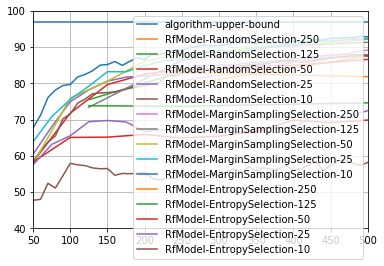

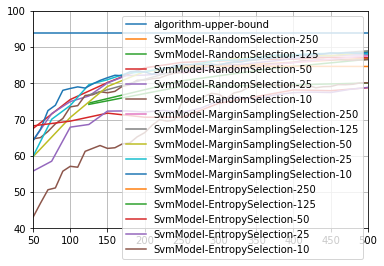

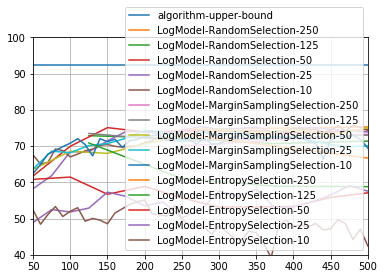

In [36]:
def performance_plot(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats):  
    fig, ax = plt.subplots()
    ax.plot([0,500],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    for model_object in models:
      for selection_function in selection_functions:
        for idx, k in enumerate(Ks):
            x = np.arange(float(Ks[idx]), 500 + float(Ks[idx]), float(Ks[idx]))            
            Sum = np.array(dic[model_object][selection_function][k][0])
            for i in range(1, repeats):
                Sum = Sum + np.array(dic[model_object][selection_function][k][i])
            mean = Sum / repeats
            ax.plot(x, mean ,label = model_object + '-' + selection_function + '-' + str(k))
    ax.legend()
    ax.set_xlim([50,500])
    ax.set_ylim([40,100])
    ax.grid(True)
    plt.show()

models_str = ['SvmModel', 'RfModel', 'LogModel']
selection_functions_str = ['RandomSelection', 'MarginSamplingSelection', 'EntropySelection']
Ks_str = ['250','125','50','25','10'] 
repeats = 1
random_forest_upper_bound = 97.
svm_upper_bound = 94.
log_upper_bound = 92.47
total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

print('So which is the better model? under the stopping condition and hyper parameters - random forest is the winner!')
performance_plot(random_forest_upper_bound, d, ['RfModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(svm_upper_bound, d, ['SvmModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(log_upper_bound, d, ['LogModel'] , selection_functions_str    , Ks_str, 1)



So which is the best sample selection function? margin sampling is the winner!


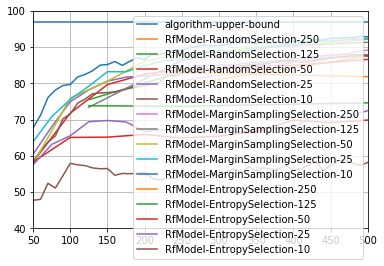


So which is the best k? k=10 is the winner


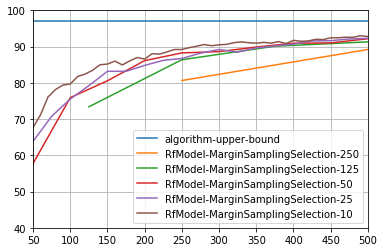

In [37]:

print('So which is the best sample selection function? margin sampling is the winner!')
performance_plot(random_forest_upper_bound, d, ['RfModel'], selection_functions_str    , Ks_str, 1)
print()
print('So which is the best k? k=10 is the winner')
performance_plot(random_forest_upper_bound, d, ['RfModel'] , ['MarginSamplingSelection'], Ks_str, 1)


I would like to thank Moshe Hadad for his valueable critique regarding PEP8 and Shay Zweig for his proof-reading and comments.

Ori Cohen has done his PhD in computer science in the fields of machine learning, brain-computer-interface and neurobiology.

[1] Shay Yehezkel, *High Dimensional Statistical Process Control and Application*, M.Sc Thesis.

[2] Ilhan, Hamza Osman, and Mehmet Fatih Amasyali. "[*Active Learning as a Way of Increasing Accuracy*](http://www.ijcte.org/papers/910-AC0013.pdf)." International Journal of Computer Theory and Engineering 6, no. 6 (2014): 460.

[3] Stefan Hosein [*Active Learning: Curious AI Algorithms*](https://www.datacamp.com/community/tutorials/active-learning)
